####HYPOTHESIS BEFORE VIEWING THE DATA  :- 
1.   Is sales more on weekends/vacations?
2.   Is traffic more on weekends/vacations?
3.   Does adv,etc. increase the sales of a course?
4.   Are courses of a trending domain bought more?
5.   Is the sales of short term course more than that of degrees? 


###Importing Libraries

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.use('Agg')
import seaborn as sns
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold,KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from scipy.stats import *

from datetime import date, timedelta
import warnings
warnings.filterwarnings("ignore")

###Importing and Viewing Dataset

In [51]:
train = pd.read_csv("/content/drive/MyDrive/Hackathon_av/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Hackathon_av/test_jY1EfQF.csv")

In [52]:
train.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,3,1,Development,Course,0,0,1,11655,0.007,75
3,4,4,1,Development,Course,0,0,1,12054,0.007,80
4,5,5,1,Development,Course,0,0,1,6804,0.007,41


In [53]:
test.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric
0,883,883,1,Development,Course,1,0,1,0.007
1,884,884,1,Development,Course,1,0,1,0.007
2,885,885,1,Development,Course,1,0,1,0.007
3,886,886,1,Development,Course,1,0,1,0.007
4,887,887,1,Development,Course,0,0,1,0.007


Test dataset doesnt contain User_Traffic column

In [54]:
train.dtypes

ID                      int64
Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
dtype: object

Possible categories : Course_ID,Course_Domain,Course_Type,Public_Holiday, Long_Promotion

In [55]:
train.nunique()

ID                    512087
Day_No                   882
Course_ID                600
Course_Domain              4
Course_Type                3
Short_Promotion            2
Public_Holiday             2
Long_Promotion             2
User_Traffic            3475
Competition_Metric       196
Sales                    544
dtype: int64

In [56]:
train.isnull().sum() 
##Only competition metric has null values. Will impute them using mean later.

ID                       0
Day_No                   0
Course_ID                0
Course_Domain            0
Course_Type              0
Short_Promotion          0
Public_Holiday           0
Long_Promotion           0
User_Traffic             0
Competition_Metric    1764
Sales                    0
dtype: int64

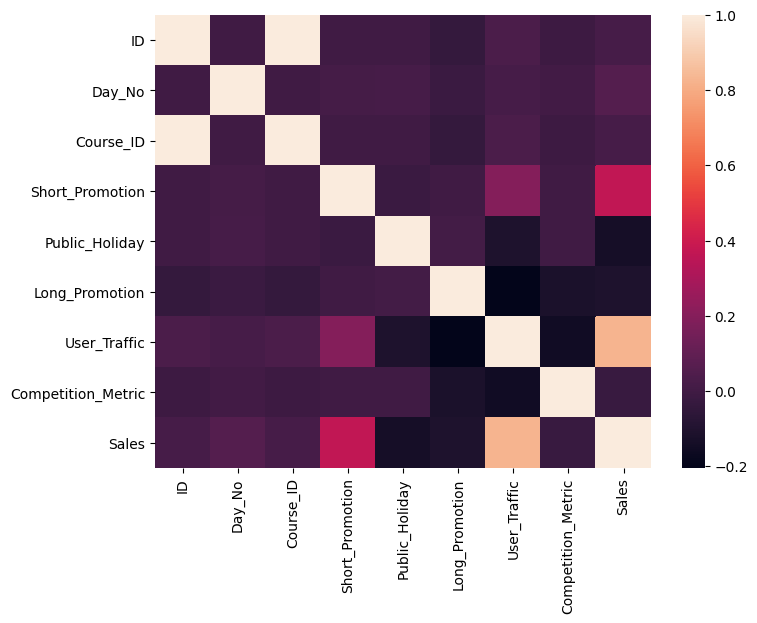

In [57]:
plt.figure(figsize=(8,6), dpi=100) 
hm=sns.heatmap(train.corr())

###EDA

In [ ]:
'''
import sweetviz as sv
report = sv.analyze(train)
report.show_html('train_report.html')
'''
'''
From the sweetviz report it can be inferred that sales column has 
highest correlation with short_promotion 
and then with course type,public holiday,course_domain,long_promotion in this given order
'''

#### 1) UNIVARIATE ANALYSIS

In [108]:
def UVA_Catg(data, column,rot):
    tot=len(column)
    for j, i in enumerate(column):  
        plt.figure(figsize=(10,3), dpi=100)    
        plt.subplot(1,tot,j+1)
        c=sns.countplot(x=i, data=data,palette='CMRmap')
        plt.title('Barplot for {}'.format(i))
        plt.xticks(rotation=rot)
        plt.rc('xtick',labelsize=8)
        #plt.tight_layout()   

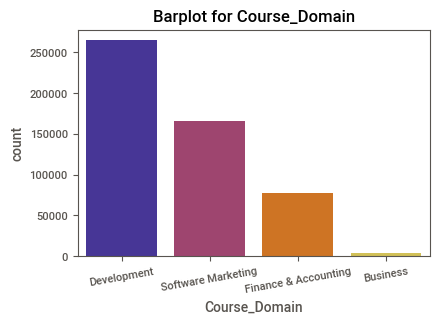

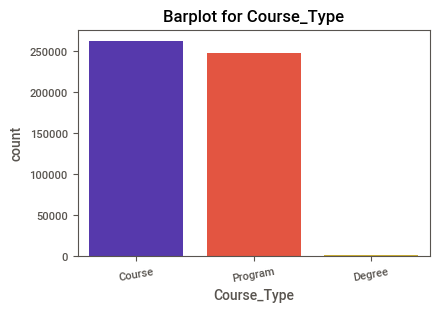

In [109]:
UVA_Catg(train, ['Course_Domain', 'Course_Type'],rot=10)

Inference 

1.   Business Courses are less in comparsion to courses of other domains
2.   Only a few degree courses are available


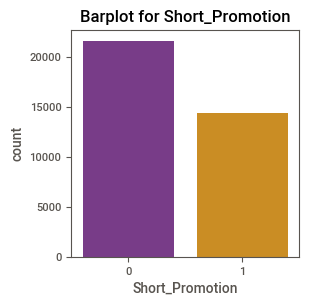

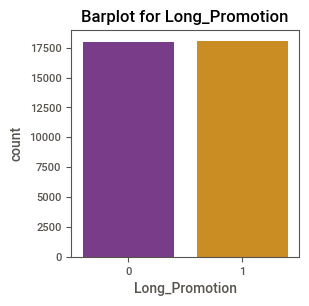

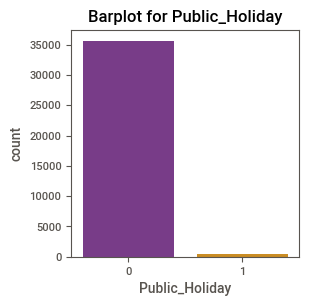

In [110]:
UVA_Catg(test, ['Short_Promotion', 'Long_Promotion', 'Public_Holiday'],0)

In [5]:
def UVA_Cont(dataplot, var, include_outlier=True):
    
    """
    Function for univariate analysis of continuous variables.
    It also takes in argument of whether to include the outliers while ploting the graphs or not.
    By default it plots graphs with outliers.
    """
    data = dataplot.copy()
    
    if include_outlier == False:
        
        #Calculating quantiles 
        quant25 = data[var].quantile(0.25)
        quant75 = data[var].quantile(0.75)
        IQR     = quant75 - quant25
        
        # Fitlering data(removing outliers)
        data[var] = data[var][(data[var] < (quant75+ 1.5*IQR)) & (data[var] > (quant25- 1.5*IQR))]
    
    
    #Calculating descriptive statistics 
    mini    = data[var].min()
    maxi    = data[var].max()
    rang    = mini - maxi
    mean    = data[var].mean()
    med     = data[var].median()
    std_    = data[var].std()
    skew    = data[var].skew()
    kurt    = data[var].kurtosis()
    quant25 = data[var].quantile(0.25)
    quant75 = data[var].quantile(0.75)
    IQR     = quant75 - quant25
    whis_low = quant25 - (1.5*IQR)
    whis_high = quant75 + (1.5*IQR)
    
    #Calculating the points of standard deviation 
    points = mean-std_, mean+std_
    
    # Calculating Number of Outliers
    outlier_high = len(data[var][data[var]>whis_high])
    outlier_low = len(data[var][data[var]<whis_low])
    

    #Plotting kdeplot 
    plt.figure(figsize=(11,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    
    sns.kdeplot(data[var],shade=True)
    sns.lineplot(points,[0,0],color='black',label='std_dev')
    sns.scatterplot([mini,maxi],[0,0],color='red',label='min\max')
    sns.scatterplot(mean,[0],color='blue',label='mean')
    sns.scatterplot(med,[0],color='green',label='median')
    plt.xlabel("{}".format(var),fontsize=(10))
    plt.ylabel('density',fontsize=(10))
    plt.tight_layout()
    plt.title('std_dev= {}; kurtosis= {};  skew= {};\nmean= {}; median= {};  range = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                               round(kurt,2),
                                                                                                 round(skew,2),
                                                                                                 round(mean,2),
                                                                                                 round(med,2),
                                                                                                 (round(mini,2),round(maxi,2),round(rang,2))),fontsize=12)
    plt.tight_layout()
        
    #Ploting boxplot 
    ax1 = plt.subplot(gs[1])
    sns.boxplot(data[var], orient="v")
    plt.title('IQR = {}; Outlier (low/high) = {};\n 2nd,3rd  quartile = {};'.format(round(IQR,2),
                                                                                            (outlier_low,outlier_high),
                                                                                            (round(quant25,2),round(quant75,2))), fontsize=14)
    plt.ylabel("{}".format(var),fontsize=(14))
    plt.tight_layout()

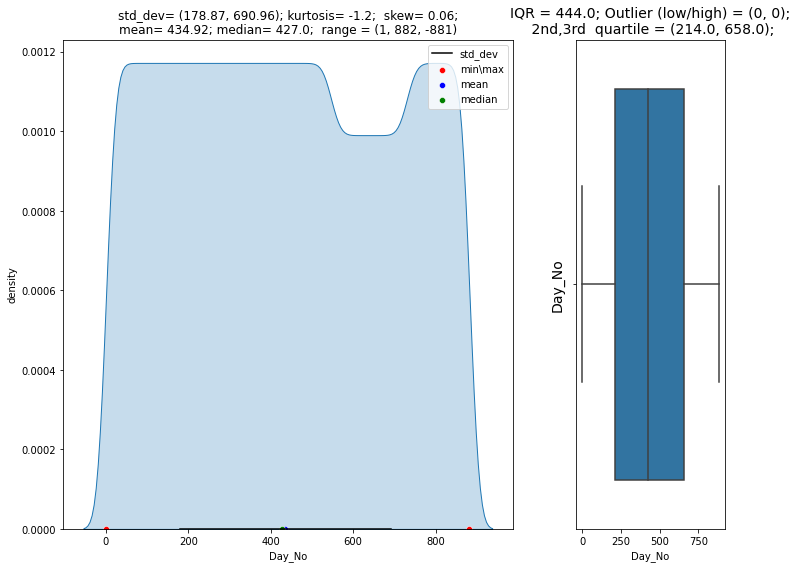

In [6]:
UVA_Cont(train, 'Day_No')

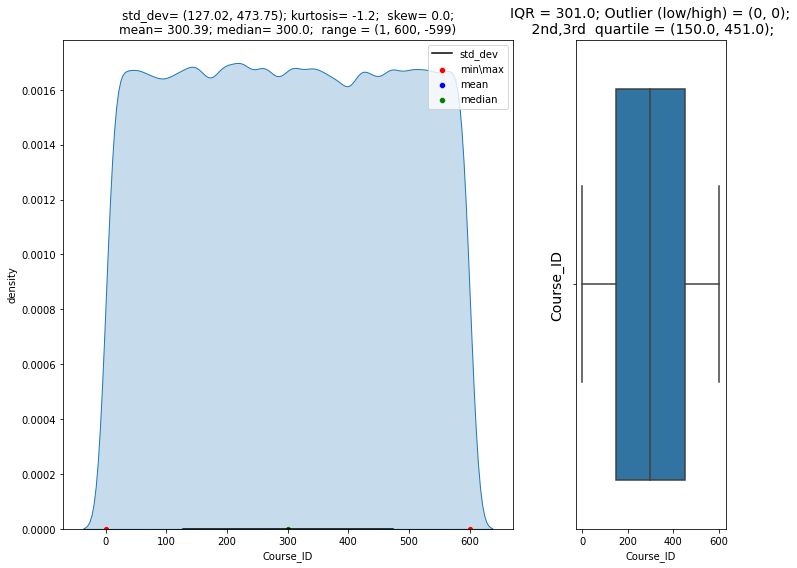

In [7]:
UVA_Cont(train, 'Course_ID')

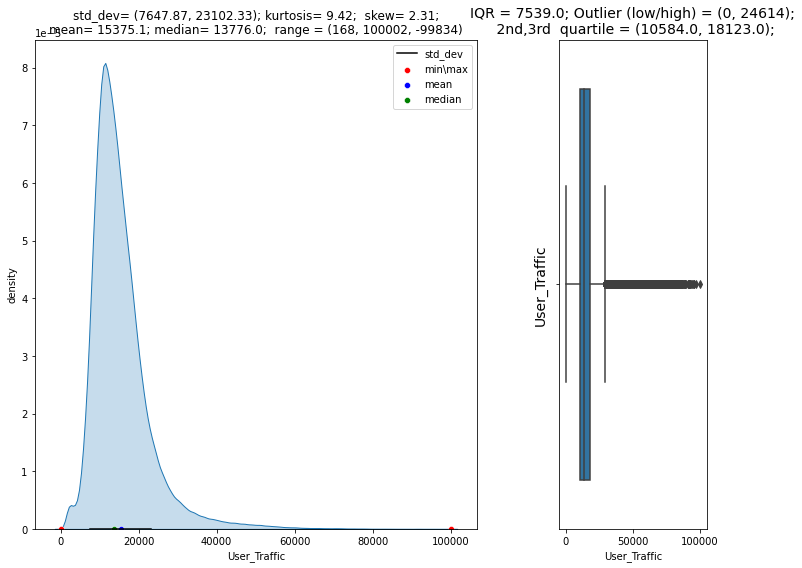

In [8]:
UVA_Cont(train, 'User_Traffic')

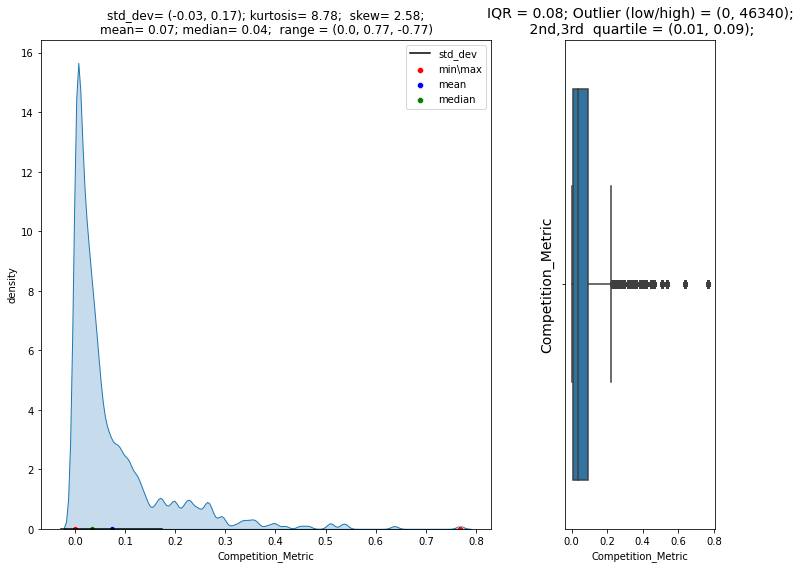

In [9]:
UVA_Cont(train,'Competition_Metric') 

####Checking our target column(Sales columns)

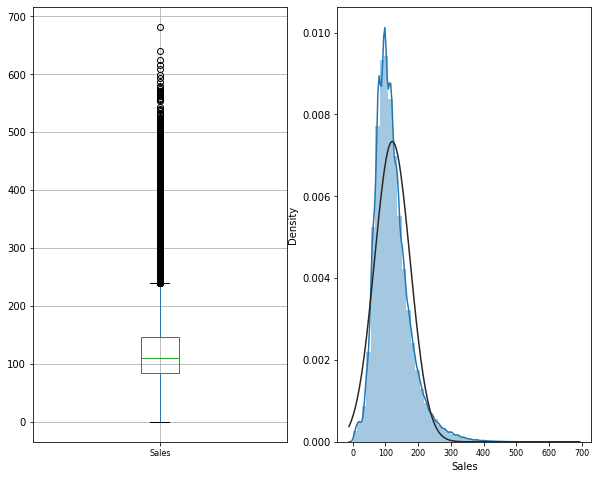

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
train[['Sales']].boxplot()
plt.subplot(1,2,2)
sns.distplot(train['Sales'], fit=norm)
plt.show()

In [ ]:
print("Skewness in sales displot= ", train['Sales'].skew())
print("Kurtosis in sales displot = ", train['Sales'].kurt())

Skewness in sales displot=  1.374769816079381
Kurtosis in sales displot =  3.6095060518605546


Inference from Univariate Analysis


1.   Competition_Metric and User_Traffic are positively  skewed 
2.   We can also infer from kde and boxplot that both Competition_Metric and User_Traffic have outliers.
3.   We can find that Sales do not follow normal distribution.Sales is postively skewed.
4.   Later we will apply a log transformation on the Sales column to reduce the skewness.



####2)Bivariate Analysis

NUMERICAL-NUMERICAL

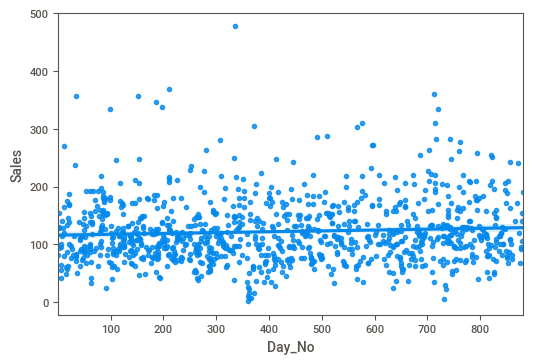

In [136]:
# plotting on sample of dataset
sampletrain= train.sample(1000)
sns.regplot(x='Day_No',y='Sales',data= sampletrain)

Inference: Day_No is not a good estimator

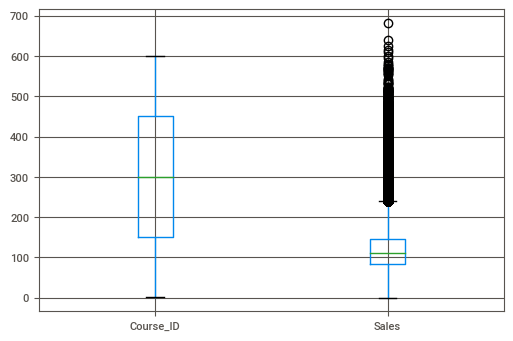

In [137]:
train[['Course_ID','Sales']].boxplot()

Inference: Data needs to be normalized

#####Categorical-Numerical

In [138]:
def catnum(x,y,data):
  sns.barplot(x=x,y=y,data=data)

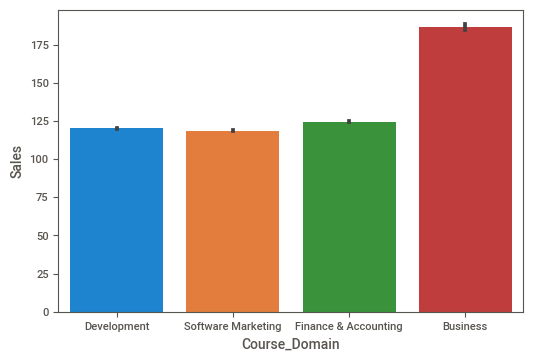

In [139]:
catnum('Course_Domain','Sales',train)

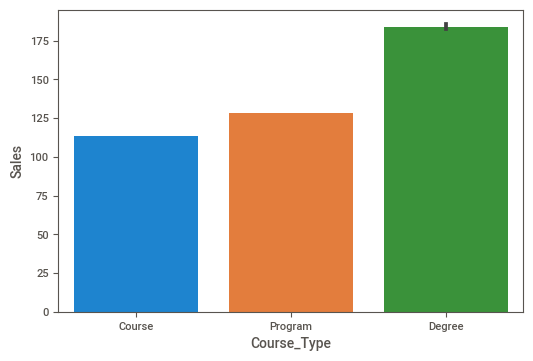

In [140]:
catnum('Course_Type','Sales',train)

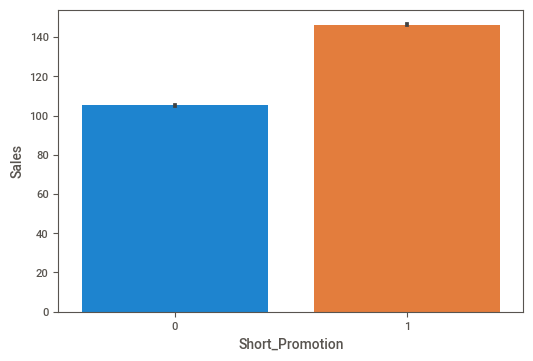

In [141]:
catnum('Short_Promotion','Sales',train)

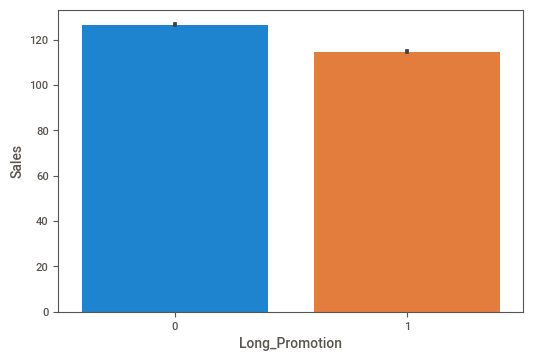

In [142]:
catnum('Long_Promotion','Sales',train)

Inference


1.   Business courses provide highest sales even though only a few business courses are available.
2.   Same happened with degree courses,they  bring in the highest revenue.
3.   When short_promotion is live sales is higher. 



####3)Multivariate Analysis

In [143]:
def Grouped_Box_Plot(data, cont, cat1, cat2):
    # boxplot
    sns.boxplot(x=cat1, y=cont, hue=cat2, data=data, orient='v')
    plt.title('Boxplot of {}, {} with {}'.format(cont,cat1,cat2))

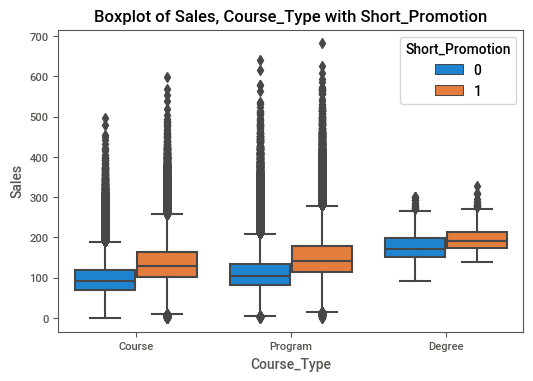

In [144]:
Grouped_Box_Plot(train,'Sales', 'Course_Type', 'Short_Promotion')

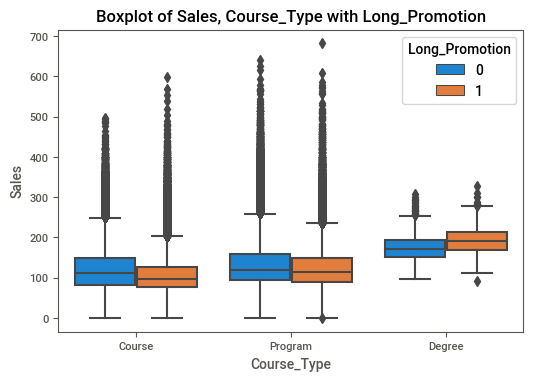

In [145]:
Grouped_Box_Plot(train,'Sales', 'Course_Type', 'Long_Promotion')

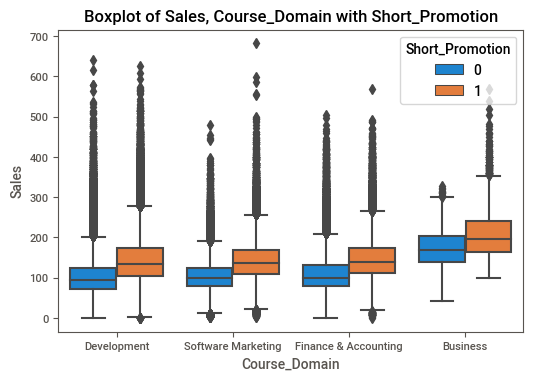

In [146]:
Grouped_Box_Plot(train,'Sales', 'Course_Domain', 'Short_Promotion')

Inference:
1.  When Short_Promotion is live sales are higher for all three course_types and all four domains.
2.   However there is no such pattern with Long_Promotion



###Log transformation of Sales column

In [11]:
train.drop(['ID'],axis=1,inplace=True)
train.head()

,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,1,Development,Course,0,0,1,11655,0.007,75
3,4,1,Development,Course,0,0,1,12054,0.007,80
4,5,1,Development,Course,0,0,1,6804,0.007,41


In [12]:
train_df=train.copy()
test_df=test.copy()
#train_df.drop(['ID'],axis=1,inplace=True)

In [49]:
#train_df['Sales'] = np.log1p(train_df['Sales'])  (stored log of sales in y2,so no need to run this again)

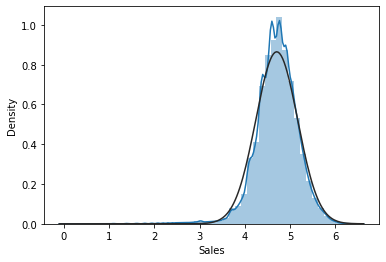

In [50]:
sns.distplot(train_df['Sales'], fit=norm)
plt.show()

Now the sales data seems more normally distributed 

###Feature engineering

In [26]:
def day_to_date(dataset):
    start = date(2018,12,31)
    dataset['Date'] = dataset['Day_No'].apply(lambda x: start + timedelta(x))

def day_month_year(dataset): 
    dataset['Day'] = dataset['Date'].apply(lambda x: x.day)
    dataset['Month'] = dataset['Date'].apply(lambda x: x.month)
    dataset['Year'] = dataset['Date'].apply(lambda x: x.year)
    dataset["Date"] = pd.to_datetime(dataset["Date"]) 
    dataset['weekofyear'] = dataset['Date'].dt.weekofyear
    
day_to_date(train_df)
day_month_year(train_df)
day_to_date(test_df)
day_month_year(test_df)

In [27]:
##There is no User_Traffic column in test set so dropping it from train set as well.
train_df.drop('User_Traffic',axis =1, inplace = True)

In [28]:
##Imputing missing competition_metric values
train_df['Competition_Metric'] = train_df.groupby('Course_ID').transform(lambda x: x.fillna(x.mean()))
#test['Competition_Metric'].fillna((test['Competition_Metric'].mean()), inplace=True)
test_df['Competition_Metric'] = test_df.groupby('Course_ID').transform(lambda x: x.fillna(x.mean()))

In [29]:
train_df['Competition_Metric'] = train_df.groupby('Course_ID').transform(lambda x: x.fillna(x.median()))
#test['Competition_Metric'].fillna((test['Competition_Metric'].mean()), inplace=True)
test_df['Competition_Metric'] = test_df.groupby('Course_ID').transform(lambda x: x.fillna(x.median()))

In [30]:
train_df['Competition_Metric']=train_df['Competition_Metric'].astype('float64')
test_df['Competition_Metric']=test_df['Competition_Metric'].astype('float64')

In [31]:
train_df['Day_of_week']=train_df['Day_No'].apply(lambda x:x%7)
test_df['Day_of_week']=test_df['Day_No'].apply(lambda x:x%7)
#train["Competition_Metric"]=df_final["Competition_Metric"].astype('float64')

In [32]:
#plt.figure(figsize=(20,20))
#sns.heatmap(df_final.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

Newly created Day, Month, Year have high correlation with Day_No and Date. So, dropping the Day_No and Date columns.

In [33]:
train_df.drop(['Day_No','Date'],axis = 1,inplace = True)
test_df.drop(['Day_No','Date'],axis = 1,inplace = True)

In [34]:
train_df.shape,test_df.shape

((512087, 13), (36000, 13))

In [35]:
train_df=pd.get_dummies(train_df,columns=['Course_Domain','Course_Type'],drop_first=True)
test_df=pd.get_dummies(test_df,columns=['Course_Domain','Course_Type'],drop_first=True)

In [ ]:
#Used one hot encoding (refer above cell) since it was giving better results than label encoding like below
'''
train_df['Course_Domain'] = train_df['Course_Domain'].map({'Development': 0,
                                                     'Software Marketing': 1,
                                                     'Finance & Accounting': 2,
                                                     'Business':3})

test_df['Course_Domain'] = test_df['Course_Domain'].map({'Development': 0,
                                                     'Software Marketing': 1,
                                                     'Finance & Accounting': 2,
                                                     'Business':3})
train_df['Course_Type'] = train_df['Course_Type'].map({'Course': 0,
                                                     'Program': 1,
                                                     'Degree': 2})
test_df['Course_Type'] = test_df['Course_Type'].map({'Course': 0,
                                                     'Program': 1,
                                                     'Degree': 2})
'''
'''
train_df["Course_Domain"] = train_df["Course_Domain"].astype('int64')
test_df["Course_Domain"] = test_df["Course_Domain"].astype('int64')
train_df["Course_Type"] = train_df["Course_Type"].astype('int64')
test_df["Course_Type"] = test_df["Course_Type"].astype('int64')
'''
'''
df_final["Course_Domain"] = df_final["Course_Domain"].astype('int64')
df_final["Course_Type"] = df_final["Course_Type"].astype('int64')
df_final.drop('ID',axis=1,inplace=True)
'''

In [39]:
numeric_feats = train_df.dtypes[train_df.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Course_Type_Degree,16.949991
Public_Holiday,5.351549
Course_Domain_Finance & Accounting,1.951906
Sales,1.374766
Course_Domain_Software Marketing,0.749701
Short_Promotion,0.493385
Year,0.432671
weekofyear,0.311034
Month,0.305964
Course_Type_Program,0.066177


###**MODEL 6** IS THE FINAL MODEL (Run Model Building cells before running Model 6 cells)

###Model Building

In [40]:
y = train_df.Sales
x = train_df.drop(['Sales'], axis=1)
x.shape, y.shape

((512087, 15), (512087,))

In [62]:
y1=train.Sales
x1=train_df.drop(['Sales'], axis=1)

In [16]:
def rmsle1000(y_true, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y_true + 1) - np.log1p(y_pred + 1), 2))) *1000

In [15]:
def print_eval_report(test_y,pred_y,test_x,model):
    print('R Squared(Accuracy)', metrics.r2_score(test_y, pred_y))   
    print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, pred_y))  
    print('Mean Squared Error:', metrics.mean_squared_error(test_y, pred_y)) 
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, pred_y)))
    print('Root Mean Squared Log Error',np.sqrt(mean_squared_log_error( test_y, pred_y )))


###Model 0: Linear regression

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(x, y , random_state =100)

In [42]:
lr = LR(normalize = True)
lr.fit(train_x, train_y)
y_predict = lr.predict(test_x)
score = rmsle1000(y_predict, test_y)
print('RMSLE score:',score)

RMSLE score: 404.5246047436514


In [43]:
Coefficients = pd.DataFrame({
    'Variable'    : x.columns,
    'coefficient' : lr.coef_
})
Coefficients.head()

,Variable,coefficient
0,Course_ID,0.001877
1,Short_Promotion,38.249966
2,Public_Holiday,-41.833367
3,Long_Promotion,-11.073444
4,Competition_Metric,-2.143776


###Model 1:Random Forest Regressor

In [ ]:
##without log of sales column
from sklearn.ensemble import RandomForestRegressor
def RandomForestRegressorModel(x,y):
    train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 100, test_size = 0.20)
    rf = RandomForestRegressor(n_estimators=20, random_state=42)
    rf.fit(train_x, train_y)
    pred_y =rf.predict(test_x)
    print(print_eval_report(test_y, pred_y, test_x, rf))
    return rf

In [ ]:
randomForestModel0 = RandomForestRegressorModel(x,y)

R Squared(Accuracy) 0.8721330273869765
Mean Absolute Error: 12.556885508406726
Mean Squared Error: 377.49668813099265
Root Mean Squared Error: 19.42927399907142
Root Mean Squared Log Error 0.16913696355963992
None


###Model 2:RF Regressor ( changing the n_estimators to 40 from 20 )




In [ ]:
##without log of sales column
from sklearn.ensemble import RandomForestRegressor
def RandomForestRegressorModel(x,y):
    train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 100, test_size = 0.20)
    rf = RandomForestRegressor(n_estimators=40, random_state=42)
    rf.fit(train_x, train_y)
    pred_y = rf.predict(test_x)
    print(print_eval_report(test_y, pred_y, test_x, rf))
    return rf

In [ ]:
randomForestModel1 = RandomForestRegressorModel(x,y)

R Squared(Accuracy) 0.8764600227234876
Mean Absolute Error: 12.380836864613643
Mean Squared Error: 364.7222681559883
Root Mean Squared Error: 19.097703216774217
Root Mean Squared Log Error 0.1669482200755977
None


###Model : GBM

In [ ]:
gb = GradientBoostingRegressor(n_estimators=600, learning_rate=0.08,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=20, min_samples_split=10, 
                                   loss='huber', random_state =100)
gb.fit(train_x, train_y)
pred_y = gb.predict(test_x)
#print(print_eval_report(test_y, pred_y, test_x, gb))

In [49]:
print(rmsle1000(pred_y,test_y))

274.46865273039407


###Model 3:XGB

In [56]:
'''
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 100, test_size = 0.20)
xgb = XGBRegressor(n_estimators=500, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb.fit(train_x, train_y)
pred_y=xgb.predict(test_x)
print(rmsle1000(test_y, pred_y))
'''

[13:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
155.3279775136209


In [57]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 100, test_size = 0.20)
xgb = XGBRegressor(n_estimators=600, max_depth=7, eta=0.1, subsample=0.6, colsample_bytree=0.8) 
xgb.fit(train_x, train_y)
pred_y=xgb.predict(test_x)
print(rmsle1000(test_y, pred_y))
##subm18

[14:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
151.75785900835666


In [53]:
# Applying k-Fold Cross Validation
'''
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgb, X = train_x, y = train_y, cv = 5)
print(accuracies)
'''

[13:12:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:16:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:20:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.91407687 0.91135708 0.91480828 0.91387697 0.91227134]


In [ ]:
'''
x1=x.drop('Year',axis=1)
train_x, test_x, train_y, test_y = train_test_split(x1, y1, random_state = 100, test_size = 0.20)
xgb = XGBRegressor(n_estimators=500, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb.fit(train_x, train_y)
pred_y=xgb.predict(test_x)
print(rmsle1000(test_y, pred_y))
'''

[21:05:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
154.89293051424048


###Model 3.1 - 3.4 :Tuning parameters of XGB

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 100, test_size = 0.20)
xgb = XGBRegressor(n_estimators=700, max_depth=7)
xgb.fit(train_x, train_y)
pred_y=xgb.predict(test_x)
print(rmsle1000(test_y, pred_y))
##submission 4 file

[20:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
149.6200934021211


Checking the feature importances in this model 3.1

In [91]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

#Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
  plt.figure(figsize=(10,8))
#Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

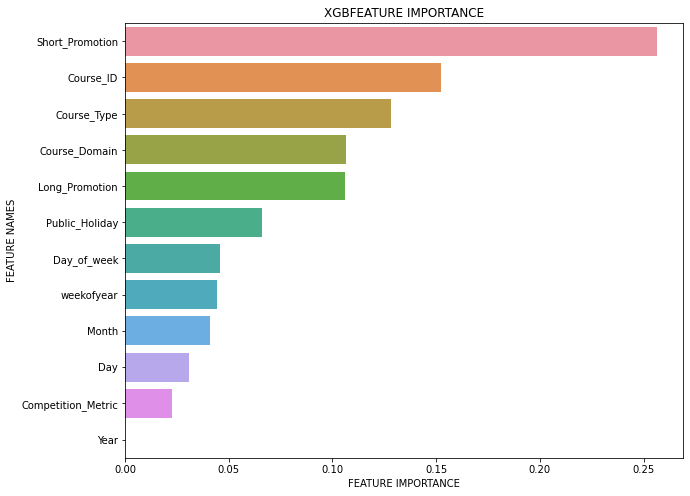

In [ ]:
plot_feature_importance(xgb.feature_importances_,x.columns,'XGB') 

XGB after dropping Year column since it is has no importance in the above feature importance graph

In [ ]:
x1=x.drop('Year',axis=1)

In [ ]:
y1=y
train_x, test_x, train_y, test_y = train_test_split(x1, y1, random_state = 100, test_size = 0.20)
xgb = XGBRegressor(n_estimators=720, max_depth=7)
xgb.fit(train_x, train_y)
pred_y=xgb.predict(test_x)
print(rmsle1000(test_y, pred_y))
##submission7

[12:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
144.14058093227624


XGB with dummies column instead of label encoding of course degree and type

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 100, test_size = 0.20)
xgb = XGBRegressor(n_estimators=700, max_depth=6)
xgb.fit(train_x, train_y)
pred_y=xgb.predict(test_x)
print(rmsle1000(test_y, pred_y))
##submission new file

[11:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
148.8762334809749


In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state=100)

cv_score =[]
i=1
for train_index,test_index in kf.split(x, y):
    print('Fold no. = ', i)
    
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #model
    xgbkf = XGBRegressor(n_estimators= 700,max_depth=7)
    xgbkf.fit(x_train, y_train)
    y_pred= xgb.predict(x_test)
    score = rmsle1000(y_test, y_pred)
    print('RMSLE score:',score)
    cv_score.append(score)    
    
    i+=1

Fold no. =  1
[11:53:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 148.87623348097497
Fold no. =  2
[12:00:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 137.76815600081548
Fold no. =  3
[12:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 139.20955227828836
Fold no. =  4
[12:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 143.54193514414175
Fold no. =  5
[12:20:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 142.72277985958956


###Model 4:Tuned XGB with cross validation


In [ ]:
kf = KFold(n_splits=5,shuffle=True,random_state=100)

cv_score =[]
i=1
for train_index,test_index in kf.split(x, y):
    print('Fold no. = ', i)
    
    x_train, x_test = x.loc[train_index], x.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    #model
    xgb = XGBRegressor(n_estimators= 700,max_depth=7)
    xgb.fit(x_train, y_train)
    y_pred= xgb.predict(x_test)
    score = rmsle1000(y_test, y_pred)
    print('RMSLE score:',score)
    cv_score.append(score)      
    i+=1

Fold no. =  1
[09:50:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 147.98548247339878
Fold no. =  2
[09:56:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 149.2854204966534
Fold no. =  3
[10:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 150.0553211043601
Fold no. =  4
[10:08:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 151.82922657181882
Fold no. =  5
[10:14:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 151.69220802084087


In [ ]:
###Gridsearch to find best parameters of xgb 
'''
param_grid = dict(
    n_jobs=[-1],
    learning_rate=[0.1, 0.5],
    objective=['reg:squarederror'],
    max_depth=[5,6,7],  
    n_estimators=[300,400,500,600,700],
    subsample=[0.2, 0.8, 1.0],
    gamma=[0.05, 0.5],
    scale_pos_weight=[0, 1],
    reg_alpha=[0, 0.5],
    reg_lambda=[1, 0],
)

model = XGBRegressor(random_state=1, verbosity=1)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           )

best_model = grid_search.fit(train_x, train_y)
print('Optimum parameters', best_model.best_params_)
'''

### Log transformation of Sales

In [66]:
y2 = np.log1p(train_df.Sales)
x2 = train_df.drop(['Sales'], axis=1)
x2.shape, y2.shape

((512087, 15), (512087,))

###Model 5:XGB With Log transformation of sales column

In [80]:
train_x, test_x, train_y, test_y = train_test_split(x2, y2, random_state = 100, test_size = 0.20)
xgb = XGBRegressor(n_estimators=500, max_depth=7,subsample=0.6, colsample_bytree=0.8)
xgb.fit(train_x, train_y)
pred_y=xgb.predict(test_x)
print(rmsle1000(np.expm1(test_y), np.expm1(pred_y)))
##subm21 (on submitting gave rmsle1000 as 147)

129.55620756824501


In [81]:
train_x, test_x, train_y, test_y = train_test_split(x2, y2, random_state = 100, test_size = 0.20)
xgb = XGBRegressor(n_estimators=600, max_depth=7,subsample=0.6, colsample_bytree=0.8)
xgb.fit(train_x, train_y)
pred_y=xgb.predict(test_x)
print(rmsle1000(np.expm1(test_y), np.expm1(pred_y)))
##subm22 

[14:54:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
125.03266679213601


###Model 6: XGB With Log transformation of Sales column and kfolds - FINAL MODEL

In [87]:
#y2 has log(x+1) of sales
kf = KFold(n_splits=5,shuffle=True,random_state=100)

cv_score =[]
i=1
for train_index,test_index in kf.split(x2, y2):
    print('Fold no. = ', i)
    
    x_train, x_test = x2.loc[train_index], x2.loc[test_index]
    y_train, y_test = y2.loc[train_index], y2.loc[test_index]
    
    #model
    xgbk = XGBRegressor(n_estimators=620, max_depth=7,subsample=0.6, colsample_bytree=0.8)
    xgbk.fit(x_train, y_train)
    y_pred= xgbk.predict(x_test)
    score = rmsle1000(np.expm1(y_test), np.expm1(y_pred))
    print('RMSLE score:',score)
    cv_score.append(score)      
    i+=1
    ##subm24

Fold no. =  1
[15:43:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 124.63222750885224
Fold no. =  2
[15:50:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 126.4889945441651
Fold no. =  3
[15:57:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 124.66521460525202
Fold no. =  4
[16:03:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 124.9404019563151
Fold no. =  5
[16:10:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE score: 126.45298638691175


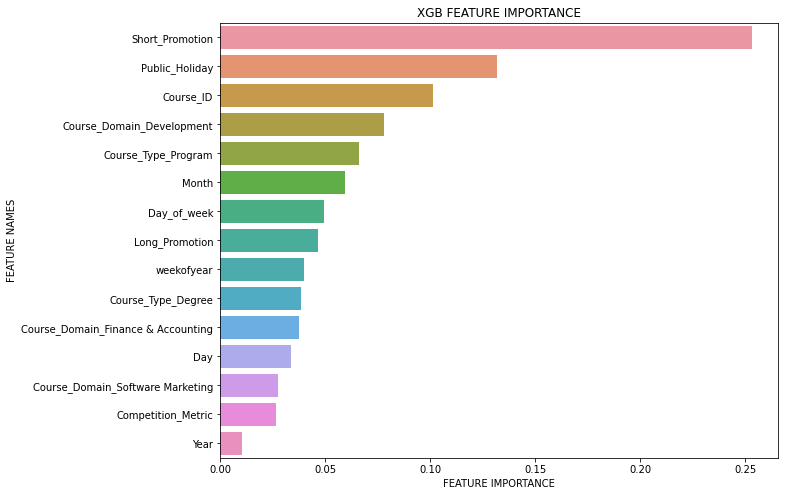

In [92]:
plot_feature_importance(xgbk.feature_importances_,x.columns,'XGB')

###Output file

In [90]:
id=test_df['ID']

In [105]:
#test_df1=test_df1.drop('Year',axis=1)

In [59]:
test_df.drop('ID',axis=1,inplace=True)

In [88]:
xgb_predicts=xgbk.predict(test_df)

In [89]:
submission = pd.DataFrame()
submission['ID'] = id
submission['Sales'] = np.expm1(xgb_predicts)
submission.to_csv('subm24.csv', index=False)
submission.head(10)

,ID,Sales
0,883,118.995087
1,884,119.117424
2,885,100.955116
3,886,95.287956
4,887,51.799915
5,888,78.525795
6,889,74.801155
7,890,75.373421
8,891,80.979507
9,892,69.708641
